# Random sampling from classified NDWI image

## Load packages

In [1]:
%matplotlib inline

import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd

In [2]:
# define area name

area_name = 'Sahel'

In [3]:
#
data = xr.open_rasterio(f'{area_name}/{area_name}_label.tif').squeeze()
dataset = data.to_dataset(name='label')

## sample from array

In [4]:
if area_name in ['Western', 'Eastern', 'Southern', 'Central']: 
    n_sample = 500
else: n_sample = 300

frac_sample = [0.1, 0.1, 0.2, 0.3, 0.3]
n_class = len(frac_sample)

# distribute points across classes
n_sample_class = (n_sample * np.array(frac_sample)).astype(int) #np.ceil(n_sample*1./ n_class).astype(int)
print(n_sample_class)

[30 30 60 90 90]


In [5]:
def pick_random_common(labelarray, label, n_sample, min_dist=0, return_index=True):
    """
    Pick random samples from a prevalent class
    
    """
    da_shape = labelarray.values.shape
    picked_y = np.array([], dtype=int)
    picked_x = np.array([], dtype=int)
    while len(picked_y) < n_sample:
        n_to_pick = n_sample - len(picked_y)
        # over sample without knowing total number of points in this class
        n_sample_over = 5*n_to_pick
        random_x = np.random.choice(np.arange(da_shape[1]), n_sample_over, replace=False)
        random_y = np.random.choice(np.arange(da_shape[0]), n_sample_over, replace=False)
        # keep points matching label
        match = labelarray.values[random_y, random_x] == label
        random_y, random_x = random_y[match], random_x[match]
        # remove points too close to previously picked ones
        if len(picked_y) > 0 and min_dist > 0:
            dist = np.sqrt((random_y-picked_y[:, None])**2 + (random_x-picked_x[:, None])**2)
            keep = dist.min(axis=0) >= min_dist
            random_y, random_x = random_y[keep], random_x[keep]
        # remove points too close to others
        if min_dist > 0:
            dist = np.sqrt((random_y-random_y[:, None])**2 + (random_x-random_x[:, None])**2)
            # set distances to themselves to min_dist
            dist[np.arange(len(random_y)), np.arange(len(random_x))] = min_dist
            keep = dist.min(axis=0) >= min_dist
            random_y, random_x = random_y[keep], random_x[keep]
        # remove extra points
        if len(random_y) > n_to_pick:
            pick = np.random.choice(np.arange(len(random_y)), n_to_pick, replace=False)
            random_y, random_x = random_y[pick], random_x[pick]
        picked_y, picked_x = np.concatenate((picked_y, random_y)), np.concatenate((picked_x, random_x))
    
    if return_index: return np.array(picked_y), np.array(picked_x)
    else: return labelarray.y[np.array(picked_y)].values, labelarray.x[np.array(picked_x)].values


def pick_random_rare(labelarray, label, n_sample, min_dist=0, return_index=True, n_points_per_batch=1):
    """
    Pick random samples from a rare class
    
    """
    
    # points will be picked from flattened index arrays
    da_shape = labelarray.values.shape
    index = np.argwhere(labelarray.values.flatten() == label).squeeze()
    index_y, index_x = np.unravel_index(index, da_shape)
    
    picked_y = np.array([], dtype=int)
    picked_x = np.array([], dtype=int)
    # pick one or a few points at a time
    while len(picked_y) < n_sample:
        picked = np.random.choice(index, n_points_per_batch, replace=False)
        # convert back to x, y 
        random_y, random_x  = np.unravel_index(picked, da_shape)
        if n_points_per_batch > 1 and min_dist > 0:
            # remove points too close to others
            dist = np.sqrt((random_y-random_y[:, None])**2 + (random_x-random_x[:, None])**2)
            dist[np.arange(len(random_y)),np.arange(len(random_x))] = min_dist
            keep = dist.min(axis=0) >= min_dist
            random_y, random_x = random_y[keep], random_x[keep]
        if min_dist > 0:
            # remove nearby points in the index array
            keep = np.sqrt((index_y-random_y[:, None])**2 + (index_x-random_x[:, None])**2).min(axis=0) >= min_dist
            index, index_y, index_x = index[keep], index_y[keep], index_x[keep]
        picked_y, picked_x = np.concatenate((picked_y, random_y)), np.concatenate((picked_x, random_x))
        
    if len(picked_y) > n_sample:
        pick = np.random.choice(np.arange(len(picked_y)), n_sample, replace=False)
        picked_y, picked_x = picked_y[pick], picked_x[pick]
    
    if return_index: return np.array(picked_y), np.array(picked_x)
    else: return labelarray.y[np.array(picked_y)].values, labelarray.x[np.array(picked_x)].values


In [6]:
%%time

from skimage.morphology import disk

min_dist_between_class = False
n_points_per_batch=1

min_dist = 1000 # this is x, y index, so 30 km 

if min_dist_between_class:
    # buffer around picked points
    offset_y, offset_x = np.where(disk(min_dist)==1)
    offset_y, offset_x = offset_y-min_dist, offset_x-min_dist

    labelarray = dataset.label.copy()
    da_shape = labelarray.values.shape
else:
    labelarray = dataset.label


label_picked = {}

class_id = 1
y, x = pick_random_common(labelarray, class_id, n_sample_class[class_id-1], min_dist=min_dist, return_index=True)
label_picked[class_id] = (y, x)

# clear out areas next to picked points
if min_dist_between_class:
    for yx in zip(y,x):
        buffer_y, buffer_x = yx[0]+offset_y, yx[1]+offset_x
        # within boundary
        mask_ind = (buffer_y>=0) & (buffer_x>=0) & (buffer_y<da_shape[0]) & (buffer_x<da_shape[1])
        labelarray.values[buffer_y[mask_ind], buffer_x[mask_ind]] = 0
    
for class_id in np.arange(2, n_class+1):
    
    y, x = pick_random_rare(labelarray, class_id, n_sample_class[class_id-1], min_dist=min_dist, return_index=True,
                            n_points_per_batch=n_points_per_batch)
    label_picked[class_id] = (y, x)

    # clear out areas next to picked points
    if min_dist_between_class:
        for yx in zip(y, x):
            buffer_y, buffer_x = yx[0]+offset_y, yx[1]+offset_x
            # within boundary
            mask_ind = (buffer_y>=0) & (buffer_x>=0) & (buffer_y<da_shape[0]) & (buffer_x<da_shape[1])
            labelarray.values[buffer_y[mask_ind], buffer_x[mask_ind]] = 0


CPU times: user 3min 54s, sys: 59.2 s, total: 4min 54s
Wall time: 4min 54s


In [7]:
# check samples and distance between samples

random_y = np.array([], dtype=int)
random_x = np.array([], dtype=int)
for label in label_picked.keys():
    check_label = dataset.label.values[label_picked[label][0], label_picked[label][1]] == label
    if np.any(~check_label):
        print("wrong type picked?", label)
    print(label, check_label.sum())
    dist = np.sqrt((label_picked[label][0]-label_picked[label][0][:, None])**2 + (label_picked[label][1]-label_picked[label][1][:, None])**2)
    max_dist = dist.max()
    dist[np.arange(len(label_picked[label][0])),np.arange(len(label_picked[label][0]))] = max_dist
    print("minimum distance in class", label, dist.min()*30/1000)
    bad = dist.min(axis=0) < min_dist
    if bad.sum()>0:
        print("check min distanctance",label, bad)
    random_y, random_x = np.concatenate((random_y, label_picked[label][0])), np.concatenate((random_x, label_picked[label][1]))
    
#check minimum distance between points
dist = np.sqrt((random_y-random_y[:, None])**2 + (random_x-random_x[:, None])**2)
max_dist = dist.max()
dist[np.arange(len(random_y)),np.arange(len(random_x))] = max_dist
print("total number of points", len(random_y))
print("minimum distance between all points", dist.min()*30/1000)


1 30
minimum distance in class 1 51.61641018125921
2 30
minimum distance in class 2 32.608564825824516
3 60
minimum distance in class 3 30.00314983464236
4 90
minimum distance in class 4 30.4836759594377
5 90
minimum distance in class 5 30.197350877187887
total number of points 300
minimum distance between all points 1.816177304119837


In [8]:
for class_id in np.arange(1, n_class+1):
    y, x = label_picked[class_id]
    df = pd.DataFrame({'y': dataset.y[y].values, 'x':dataset.x[x].values})
    #df = pd.read_csv(f'{area_name}/{area_name}_class_{class_id}.csv', header=None, names=['y','x'] )
    df['class']=class_id
    if class_id ==1: 
        dfs = df
    else: 
        dfs = dfs.append(df, ignore_index=True)

len(dfs)

300

In [9]:
gdf = gpd.GeoDataFrame(
        dfs,
        crs=dataset.label.crs,
        geometry=gpd.points_from_xy(dfs.x, dfs.y)).reset_index()

gdf = gdf.drop(['x', 'y'],axis=1)

if min_dist_between_class:
    gdf.to_file(f'{area_name}/{area_name}_samples_min_dist_between_class.shp')
else:
    gdf.to_file(f'{area_name}/{area_name}_samples.shp')

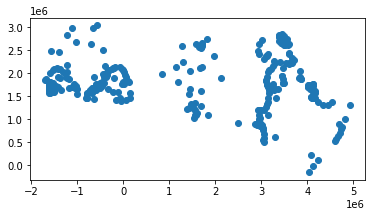

In [10]:
gdf.plot()